### SetUp

In [ ]:
import torch
import nvtx
import time
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

### Test1: AbsMax Overhead for 3 different quantization methods(per Tensor, Token, Channel)

In [3]:
@torch.no_grad()
def dynamic_quantize_activation_per_tensor_absmax(t):
    # Input: t (B, C, D) tensor
    s_total = torch.cuda.Event(enable_timing=True)
    e_total = torch.cuda.Event(enable_timing=True)
    s_abs   = torch.cuda.Event(enable_timing=True)
    e_abs   = torch.cuda.Event(enable_timing=True)

    # 전체 측정 시작
    s_total.record()

    # absmax 구간 측정
    with nvtx.annotate("absmax_per_tensor", color="red"):
        s_abs.record()
        max_val = t.abs().max()
        e_abs.record()

    # 나머지 연산
    max_val = torch.clamp(max_val, min=1e-8) / 127
    t.div_(max_val).round_().clamp_(-128, 127)
    q_act = t.to(torch.int8)

    # 전체 측정 종료
    e_total.record()

    # 이벤트 동기화
    e_total.synchronize()  # total이 끝날 때까지 대기

    # 시간(ms) → μs로 변환
    total_time_us = s_total.elapsed_time(e_total) * 1e3
    abs_time_us   = s_abs.elapsed_time(e_abs) * 1e3

    return q_act, max_val, total_time_us, abs_time_us


@torch.no_grad()
def dynamic_quantize_activation_per_token_absmax(t):
    # Input: t (B, C, D) tensor
    s_total = torch.cuda.Event(enable_timing=True)
    e_total = torch.cuda.Event(enable_timing=True)
    s_abs   = torch.cuda.Event(enable_timing=True)
    e_abs   = torch.cuda.Event(enable_timing=True)

    # 전체 측정 시작
    s_total.record()
    with nvtx.annotate("absmax_per_token", color="green"):
        s_abs.record()
        max_val = t.abs().max(dim=-1, keepdim=True)[0]
        e_abs.record()

    max_val = torch.clamp(max_val, min=1e-8) / 127
    t.div_(max_val).round_().clamp_(-128, 127)
    q_act = t.to(torch.int8)
    
    # 전체 측정 종료
    e_total.record()
    # 이벤트 동기화
    e_total.synchronize()  # total이 끝날 때까지 대기

    # 시간(ms) → μs로 변환
    total_time_us = s_total.elapsed_time(e_total) * 1e3
    abs_time_us   = s_abs.elapsed_time(e_abs) * 1e3

    return q_act, max_val, total_time_us, abs_time_us


@torch.no_grad()
def dynamic_quantize_activation_per_channel_absmax(t):
    # Input: t (B, C, D) tensor
    s_total = torch.cuda.Event(enable_timing=True)
    e_total = torch.cuda.Event(enable_timing=True)
    s_abs   = torch.cuda.Event(enable_timing=True)
    e_abs   = torch.cuda.Event(enable_timing=True)

    # 전체 측정 시작
    s_total.record()

    with nvtx.annotate("absmax_per_channel", color="blue"):
        s_abs.record()
        max_val = t.abs().amax(dim=(0,1), keepdim=True)
        e_abs.record()

    max_val = torch.clamp(max_val, min=1e-8) / 127
    t.div_(max_val).round_().clamp_(-128, 127)
    q_act = t.to(torch.int8)
    
    # 전체 측정 종료
    e_total.record()
    # 이벤트 동기화
    e_total.synchronize()  # total이 끝날 때까지 대기

    # 시간(ms) → μs로 변환
    total_time_us = s_total.elapsed_time(e_total) * 1e3
    abs_time_us   = s_abs.elapsed_time(e_abs) * 1e3

    return q_act, max_val, total_time_us, abs_time_us


def bench(fn, x, iters=300, warmup=50):
    # warmup
    for _ in range(warmup):
        fn(x.clone())

    total_times, abs_times = [], []
    for _ in range(iters):
        _, _, total_us, abs_us = fn(x.clone())
        total_times.append(total_us)
        abs_times.append(abs_us)

    avg_total = sum(total_times) / len(total_times)
    avg_abs   = sum(abs_times) / len(abs_times)
    ratio     = (avg_abs / avg_total) * 100 if avg_total > 0 else 0
    return avg_total, avg_abs, ratio


# Test
B, C, D = 10, 1000, 1024
x = torch.randn(B, C, D, device="cuda", dtype=torch.float16)

for name, fn in [
    ("Per-tensor", dynamic_quantize_activation_per_tensor_absmax),
    ("Per-token", dynamic_quantize_activation_per_token_absmax),
    ("Per-channel", dynamic_quantize_activation_per_channel_absmax),
]:
    total_us, abs_us, ratio = bench(fn, x)
    print(f"{name:11}: total={total_us:.2f} us | absmax={abs_us:.2f} us | {ratio:.1f}%")

Per-tensor : total=356.93 us | absmax=106.79 us | 29.9%
Per-token  : total=356.53 us | absmax=106.14 us | 29.8%
Per-channel: total=361.11 us | absmax=111.71 us | 30.9%


In [ ]:
# -------------------------------
# Testing data collection
# -------------------------------
# (Left) B=10, D=2048, C changes
B_fixed = 10
D_fixed = 2048
C_list = [2000, 4000, 8000]
total_left, abs_left, ratio_left = [], [], []

for C in C_list:
    x = torch.randn(B_fixed, C, D_fixed, device="cuda", dtype=torch.float16)
    t_total, t_abs, _ = bench(dynamic_quantize_activation_per_tensor_absmax, x)
    total_left.append(t_total)
    abs_left.append(t_abs)
    ratio_left.append(t_abs / t_total * 100)

print("C Finished")

# (Right) C=4000, D=2048, B changes
C_fixed = 4000
B_list = [20, 40, 80]
total_right, abs_right, ratio_right = [], [], []

for B in B_list:
    x = torch.randn(B, C_fixed, D_fixed, device="cuda", dtype=torch.float16)
    t_total, t_abs, _ = bench(dynamic_quantize_activation_per_tensor_absmax, x)
    total_right.append(t_total)
    abs_right.append(t_abs)
    ratio_right.append(t_abs / t_total * 100)
    
print("B Finished")

C Finished
B Finished


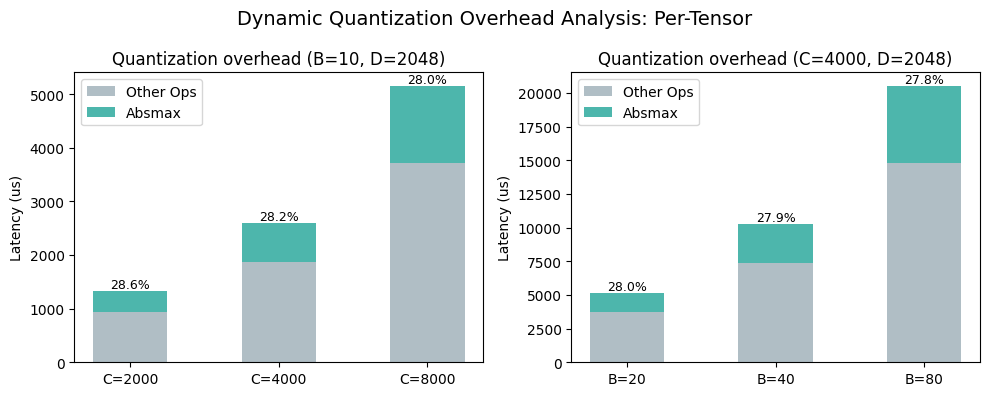

In [8]:
# -------------------------------
# 그래프 그리기
# -------------------------------
labels_left = [f"C={c}" for c in C_list]
labels_right = [f"B={b}" for b in B_list]
x_left = np.arange(len(labels_left))
x_right = np.arange(len(labels_right))
width = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# (a) C 변화
axs[0].bar(x_left, np.array(total_left) - np.array(abs_left), width, label='Other Ops', color='#B0BEC5')
axs[0].bar(x_left, abs_left, width, bottom=np.array(total_left) - np.array(abs_left),
           label='Absmax', color='#4DB6AC')
axs[0].set_xticks(x_left)
axs[0].set_xticklabels(labels_left)
axs[0].set_ylabel('Latency (us)')
axs[0].set_title('Quantization overhead (B=10, D=2048)')
axs[0].legend()
for i, (t, r) in enumerate(zip(total_left, ratio_left)):
    axs[0].text(i, t + 5, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)

# (b) B 변화
axs[1].bar(x_right, np.array(total_right) - np.array(abs_right), width, label='Other Ops', color='#B0BEC5')
axs[1].bar(x_right, abs_right, width, bottom=np.array(total_right) - np.array(abs_right),
           label='Absmax', color='#4DB6AC')
axs[1].set_xticks(x_right)
axs[1].set_xticklabels(labels_right)
axs[1].set_ylabel('Latency (us)')
axs[1].set_title('Quantization overhead (C=4000, D=2048)')
axs[1].legend()
for i, (t, r) in enumerate(zip(total_right, ratio_right)):
    axs[1].text(i, t + 5, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)

fig.suptitle('Dynamic Quantization Overhead Analysis: Per-Tensor', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
B_fixed = 10
D_fixed = 2048
C_list = [2000, 4000, 8000]
total_left, abs_left, ratio_left = [], [], []

for C in C_list:
    x = torch.randn(B_fixed, C, D_fixed, device="cuda", dtype=torch.float16)
    t_total, t_abs, _ = bench(dynamic_quantize_activation_per_token_absmax, x)
    total_left.append(t_total)
    abs_left.append(t_abs)
    ratio_left.append(t_abs / t_total * 100)

print("C Finished")

C_fixed = 4000
B_list = [20, 40, 80]
total_right, abs_right, ratio_right = [], [], []

for B in B_list:
    x = torch.randn(B, C_fixed, D_fixed, device="cuda", dtype=torch.float16)
    t_total, t_abs, _ = bench(dynamic_quantize_activation_per_token_absmax, x)
    total_right.append(t_total)
    abs_right.append(t_abs)
    ratio_right.append(t_abs / t_total * 100)
    
print("B Finished")

C Finished
B Finished


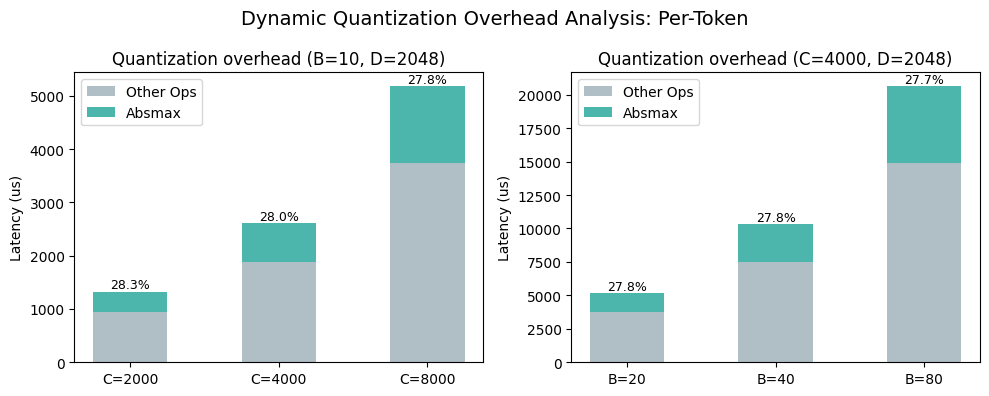

In [11]:
labels_left = [f"C={c}" for c in C_list]
labels_right = [f"B={b}" for b in B_list]
x_left = np.arange(len(labels_left))
x_right = np.arange(len(labels_right))
width = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# (a) C 변화
axs[0].bar(x_left, np.array(total_left) - np.array(abs_left), width, label='Other Ops', color='#B0BEC5')
axs[0].bar(x_left, abs_left, width, bottom=np.array(total_left) - np.array(abs_left),
           label='Absmax', color='#4DB6AC')
axs[0].set_xticks(x_left)
axs[0].set_xticklabels(labels_left)
axs[0].set_ylabel('Latency (us)')
axs[0].set_title('Quantization overhead (B=10, D=2048)')
axs[0].legend()
for i, (t, r) in enumerate(zip(total_left, ratio_left)):
    axs[0].text(i, t + 5, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)

# (b) B 변화
axs[1].bar(x_right, np.array(total_right) - np.array(abs_right), width, label='Other Ops', color='#B0BEC5')
axs[1].bar(x_right, abs_right, width, bottom=np.array(total_right) - np.array(abs_right),
           label='Absmax', color='#4DB6AC')
axs[1].set_xticks(x_right)
axs[1].set_xticklabels(labels_right)
axs[1].set_ylabel('Latency (us)')
axs[1].set_title('Quantization overhead (C=4000, D=2048)')
axs[1].legend()
for i, (t, r) in enumerate(zip(total_right, ratio_right)):
    axs[1].text(i, t + 5, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)

fig.suptitle('Dynamic Quantization Overhead Analysis: Per-Token', fontsize=14)

plt.tight_layout()
plt.show()

In [12]:
B_fixed = 10
D_fixed = 2048
C_list = [2000, 4000, 8000]
total_left, abs_left, ratio_left = [], [], []

for C in C_list:
    x = torch.randn(B_fixed, C, D_fixed, device="cuda", dtype=torch.float16)
    t_total, t_abs, _ = bench(dynamic_quantize_activation_per_channel_absmax, x)
    total_left.append(t_total)
    abs_left.append(t_abs)
    ratio_left.append(t_abs / t_total * 100)

print("C Finished")

C_fixed = 4000
B_list = [20, 40, 80]
total_right, abs_right, ratio_right = [], [], []

for B in B_list:
    x = torch.randn(B, C_fixed, D_fixed, device="cuda", dtype=torch.float16)
    t_total, t_abs, _ = bench(dynamic_quantize_activation_per_channel_absmax, x)
    total_right.append(t_total)
    abs_right.append(t_abs)
    ratio_right.append(t_abs / t_total * 100)
    
print("B Finished")

C Finished
B Finished


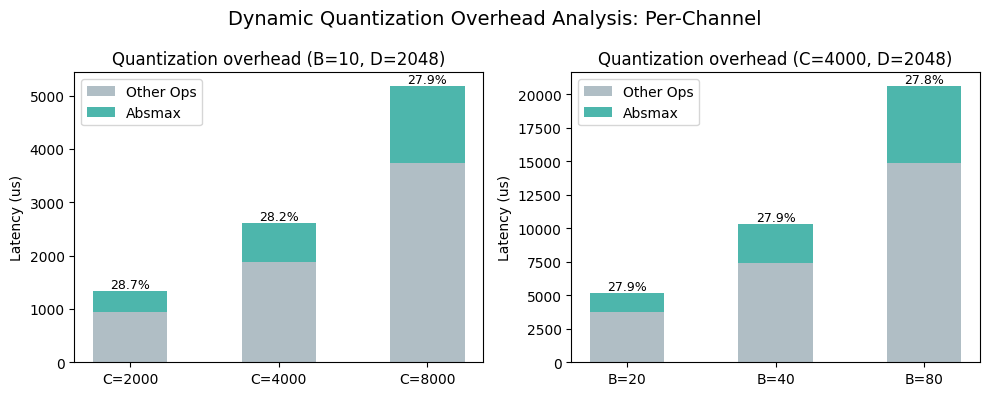

In [13]:
labels_left = [f"C={c}" for c in C_list]
labels_right = [f"B={b}" for b in B_list]
x_left = np.arange(len(labels_left))
x_right = np.arange(len(labels_right))
width = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(x_left, np.array(total_left) - np.array(abs_left), width, label='Other Ops', color='#B0BEC5')
axs[0].bar(x_left, abs_left, width, bottom=np.array(total_left) - np.array(abs_left),
           label='Absmax', color='#4DB6AC')
axs[0].set_xticks(x_left)
axs[0].set_xticklabels(labels_left)
axs[0].set_ylabel('Latency (us)')
axs[0].set_title('Quantization overhead (B=10, D=2048)')
axs[0].legend()
for i, (t, r) in enumerate(zip(total_left, ratio_left)):
    axs[0].text(i, t + 5, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)

axs[1].bar(x_right, np.array(total_right) - np.array(abs_right), width, label='Other Ops', color='#B0BEC5')
axs[1].bar(x_right, abs_right, width, bottom=np.array(total_right) - np.array(abs_right),
           label='Absmax', color='#4DB6AC')
axs[1].set_xticks(x_right)
axs[1].set_xticklabels(labels_right)
axs[1].set_ylabel('Latency (us)')
axs[1].set_title('Quantization overhead (C=4000, D=2048)')
axs[1].legend()
for i, (t, r) in enumerate(zip(total_right, ratio_right)):
    axs[1].text(i, t + 5, f"{r:.1f}%", ha='center', va='bottom', fontsize=9)

fig.suptitle('Dynamic Quantization Overhead Analysis: Per-Channel', fontsize=14)

plt.tight_layout()
plt.show()